In [25]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# stacking
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.linear_model  import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

# 2. Load pandas DataFrame

In [2]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [3]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [4]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')


# Separando el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformando los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')


# Ajustando la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)


df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraer las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unir los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [5]:
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes


df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

df_final = df_final.dropna()

In [6]:
# Cambiar anno, mes, dia, diasem y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

In [7]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] #Weekday is numerical in this case - Intervention variables
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'Utilizacion'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

## Divide the data into training and test sets ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test


In [8]:
len(X_train)

11692

In [9]:
len(X_test)

2924

# 3. Fit the model

### 3.1 Polynomial model

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge

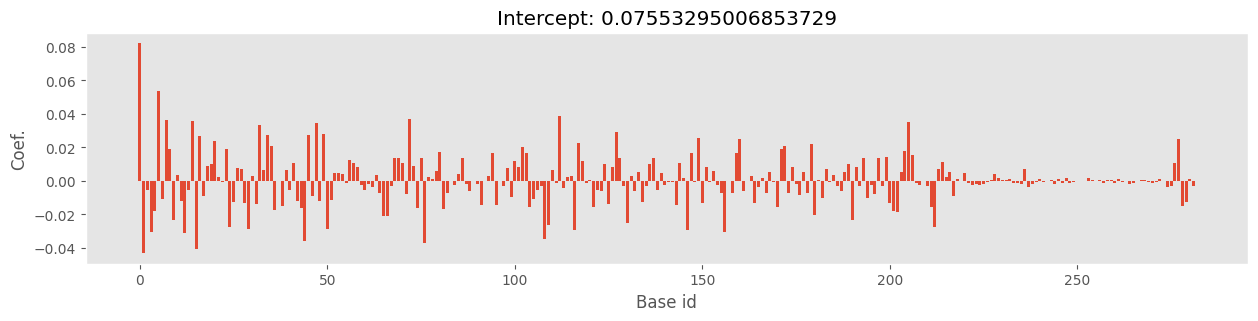

In [16]:
# Transformador para variables numéricas con características polinomiales
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Polinomios de grado 15
])

# Transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesador que aplica las transformaciones definidas
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_NUM),
    ('cat', categorical_transformer, INPUTS_CAT)
])

# Completa el pipeline con Ridge Regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.1))
])

# Entrenar el modelo
ridge_pipeline.fit(X_train, y_train)

# Opcional: Visualización de los coeficientes (sería necesario ajustar esto para que tenga sentido)
X_train_transformed = ridge_pipeline.named_steps['preprocessor'].transform(X_train)
degree_plus_features = X_train_transformed.shape[1]  # Número de características transformadas

plt.figure(figsize=(15, 3))
plt.bar(range(degree_plus_features), ridge_pipeline.named_steps['ridge'].coef_)
plt.title(f'Intercept: {ridge_pipeline.named_steps["ridge"].intercept_}')
plt.xlabel('Base id')
plt.ylabel('Coef.')
plt.grid()
plt.show()

Compute errors of the polynomial

In [17]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['pol_pred'] = ridge_pipeline.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['pol_pred'] = ridge_pipeline.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['pol_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['pol_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['pol_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['pol_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['pol_pred']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['pol_pred']))

Training MAE: 0.014906616053570536
Test MAE: 0.015838366250583286
Training RMSE: 0.025300621064696275
Test RMSE: 0.026658292554974553
Training R2: 0.9522522863791588
Test R2: 0.945358511011888


### 3.2 B-spline model

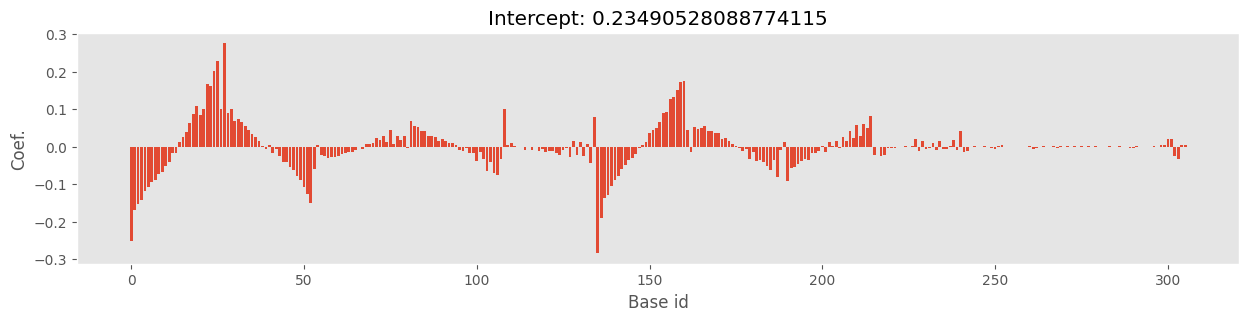

In [18]:
# Transformador para variables numéricas con características polinomiales
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('splt', SplineTransformer(n_knots=25, degree=3))  # Polinomios de grado 15
])

# Transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesador que aplica las transformaciones definidas
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_NUM),
    ('cat', categorical_transformer, INPUTS_CAT)
])

# Completa el pipeline con Ridge Regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.1))
])

# Entrenar el modelo
ridge_pipeline.fit(X_train, y_train)

# Opcional: Visualización de los coeficientes (sería necesario ajustar esto para que tenga sentido)
X_train_transformed = ridge_pipeline.named_steps['preprocessor'].transform(X_train)
degree_plus_features = X_train_transformed.shape[1]  # Número de características transformadas

plt.figure(figsize=(15, 3))
plt.bar(range(degree_plus_features), ridge_pipeline.named_steps['ridge'].coef_)
plt.title(f'Intercept: {ridge_pipeline.named_steps["ridge"].intercept_}')
plt.xlabel('Base id')
plt.ylabel('Coef.')
plt.grid()
plt.show()

In [19]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['splt'] = ridge_pipeline.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['splt'] = ridge_pipeline.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['splt']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['splt']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['splt'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['splt'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['splt']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['splt']))

Training MAE: 0.018812607278808516
Test MAE: 0.019782988915699184
Training RMSE: 0.02923914268800413
Test RMSE: 0.031054901708368648
Training R2: 0.9362295494307444
Test R2: 0.925848799944016


### 3.3 Simple Regression Tree

In [20]:
# Inputs of the model
INPUTS_DT = INPUTS

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
                       
single_reg_tree_fit.fit(X_train, y_train) # Search in grid

c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\pipeline.py", line 420,

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [23]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['regtree'] = single_reg_tree_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['regtree'] = single_reg_tree_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['regtree']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['regtree']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['regtree'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['regtree'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['regtree']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['regtree']))

Training MAE: 0.010256035194095913
Test MAE: 0.016525688289265983
Training RMSE: 0.019837568229661554
Test RMSE: 0.031931721318362194
Training R2: 0.9706460139734515
Test R2: 0.9216024435164134


#### 3.4. Stacking

In [26]:
degree_poly = 3

n_knots_spline = 25 # number of "breaking points"
degree_basis_spline = 3 # order of the basis polynomials

# grid in min_impurity x min_samples_leaf x min_samples_split
param_tree = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

pipe_tree = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                         random_state=150))]) # For replication

nFolds_tree = 10

## set of estimators to be stacked
estimators = [
    ('poly', make_pipeline(
        PolynomialFeatures(degree_poly), 
        Ridge(alpha=1e-3))
    ),
    ('spline', make_pipeline(
        SplineTransformer(n_knots=25, degree=3),
        Ridge(alpha=1e-3))
    ),
    ('regtree', make_pipeline(
                GridSearchCV(estimator= pipe_tree,
                            param_grid=param_tree, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            cv=nFolds_tree)) # Number of Folds
    )
]

estimators

[('poly',
  Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('spline',
  Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('regtree',
  Pipeline(steps=[('gridsearchcv',
                   GridSearchCV(cv=10,
                                estimator=Pipeline(steps=[('DT',
                                                           DecisionTreeRegressor(random_state=150))]),
                                n_jobs=-1,
                                param_grid={'DT__min_impurity_decrease': array([0.]),
                                            'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                            'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}))]))]

In [27]:
weights = [0.1, 0.2, 0.7]
stacked_reg = VotingRegressor(estimators = estimators, weights = weights)
stacked_reg = stacked_reg.fit(X_train, y_train)
stacked_reg.get_params()

c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.21887e-46): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-

{'estimators': [('poly',
   Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('spline',
   Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('regtree',
   Pipeline(steps=[('gridsearchcv',
                    GridSearchCV(cv=10,
                                 estimator=Pipeline(steps=[('DT',
                                                            DecisionTreeRegressor(random_state=150))]),
                                 n_jobs=-1,
                                 param_grid={'DT__min_impurity_decrease': array([0.]),
                                             'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                             'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}))]))],
 'n_jobs': None,
 'verbose': False,
 'weights': [0.1, 0.2, 0.7],
 'poly': Pipeline(steps=[('polynomia

In [28]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['stack'] = stacked_reg.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['stack'] = stacked_reg.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['stack']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['stack']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['stack'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['stack'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['stack']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['stack']))

Training MAE: 0.010742563562994554
Test MAE: 0.015411959447267802
Training RMSE: 0.019549064750424696
Test RMSE: 0.028579673266652488
Training R2: 0.9714936123715824
Test R2: 0.9371981575656826


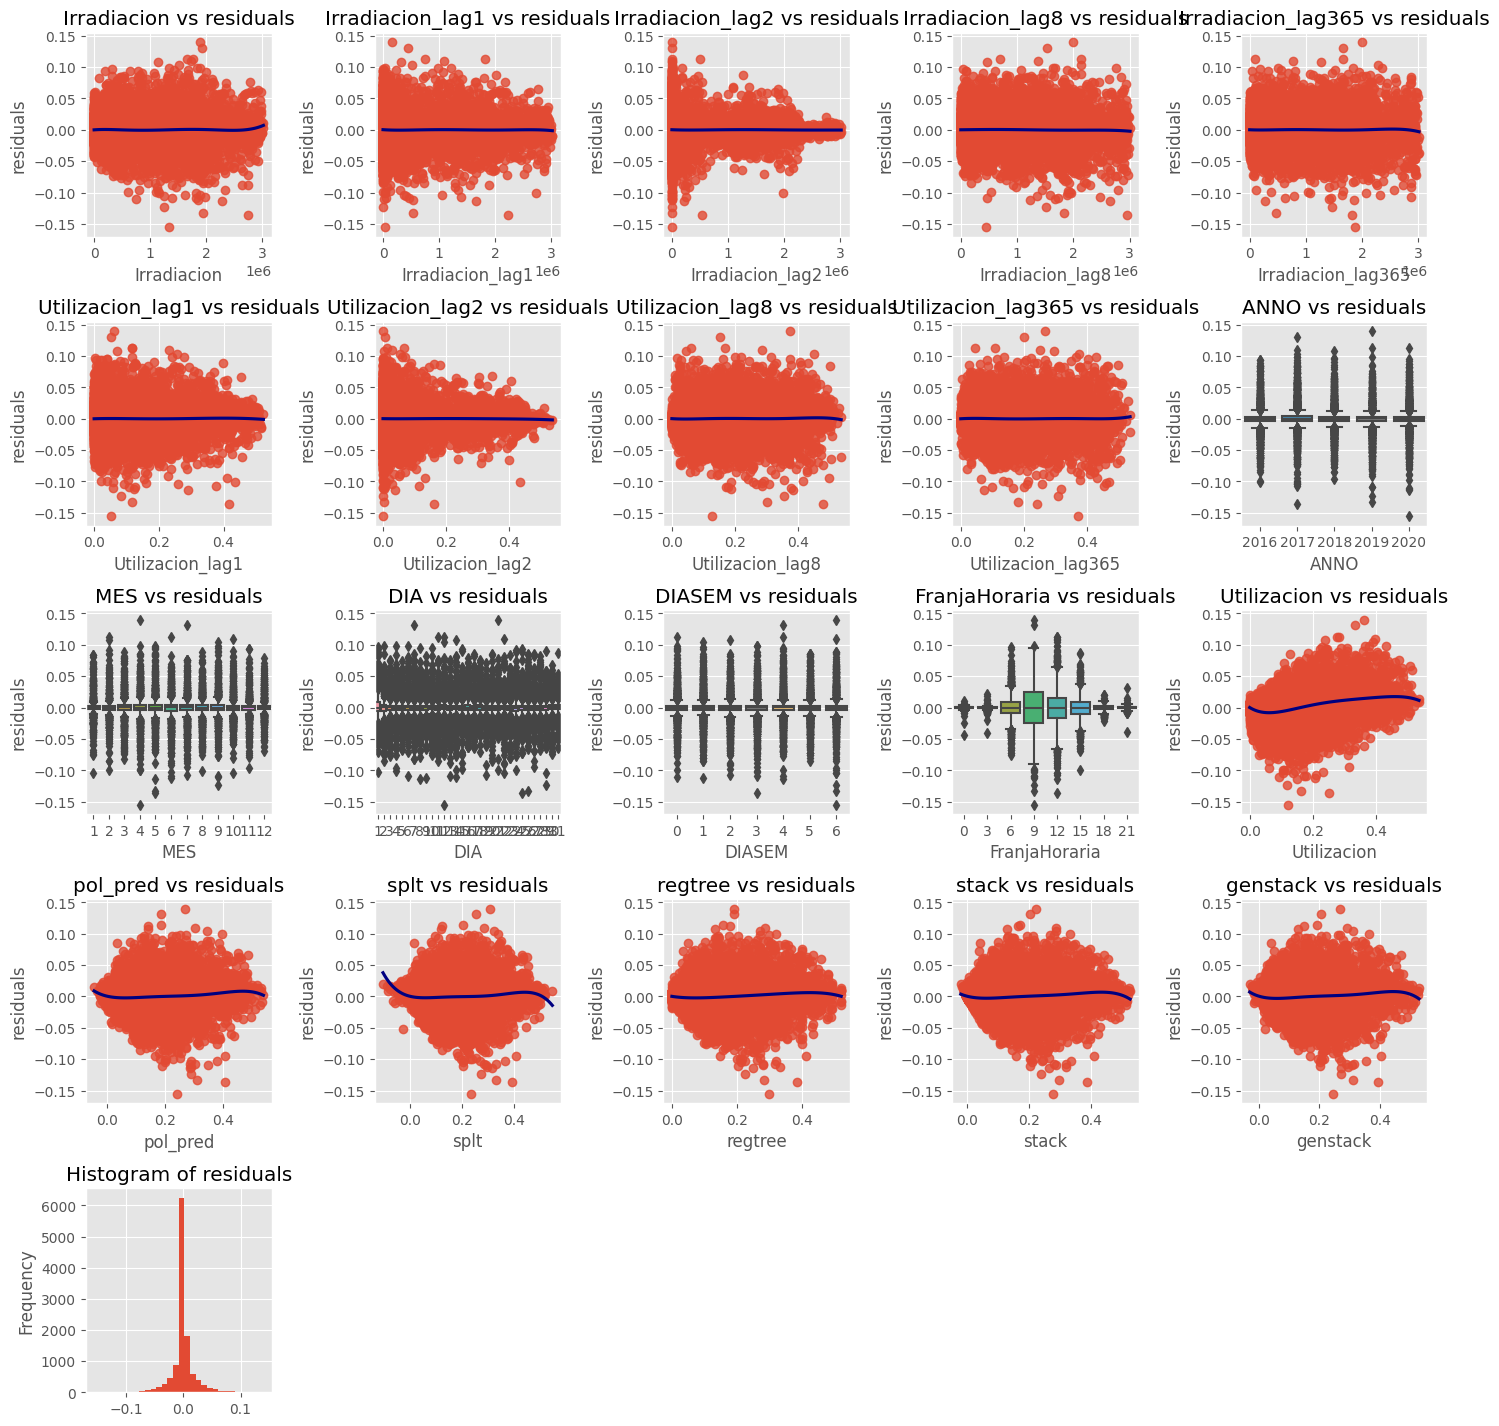

In [34]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'stack', 'Utilizacion', figsize=[15,15])

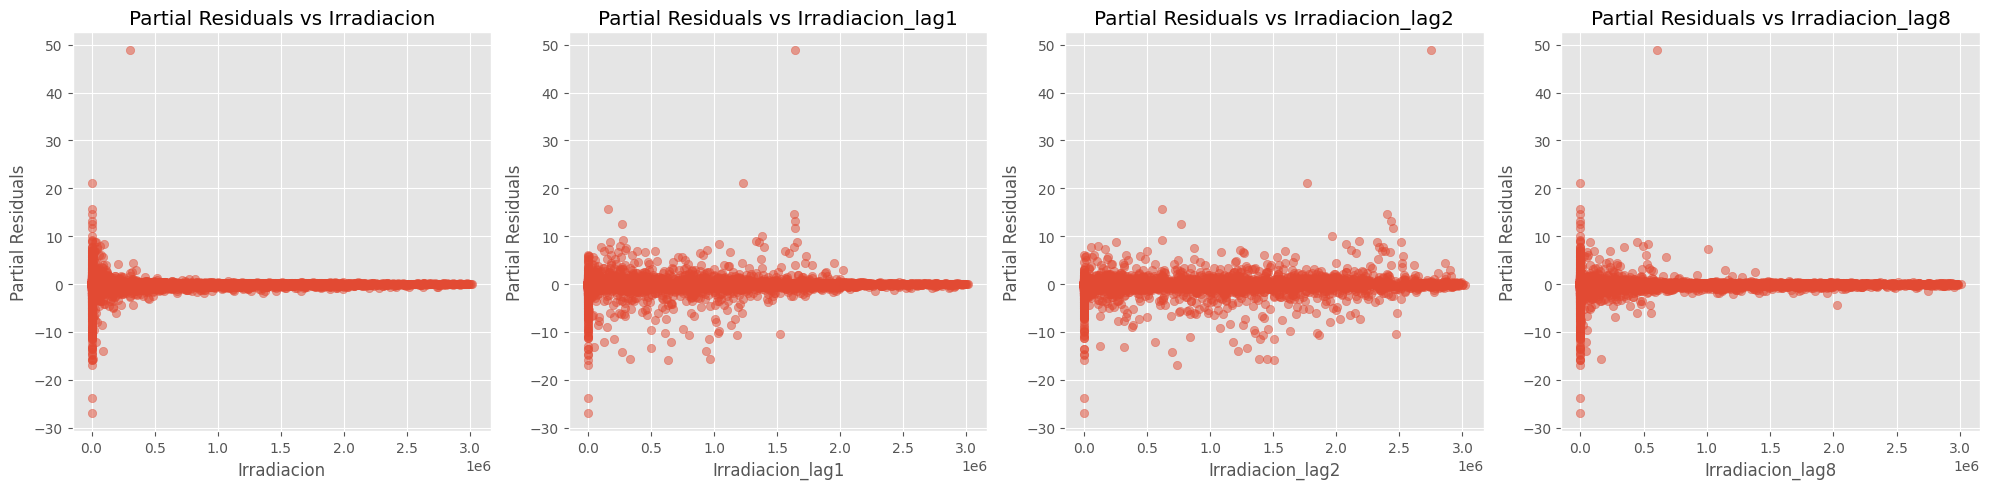

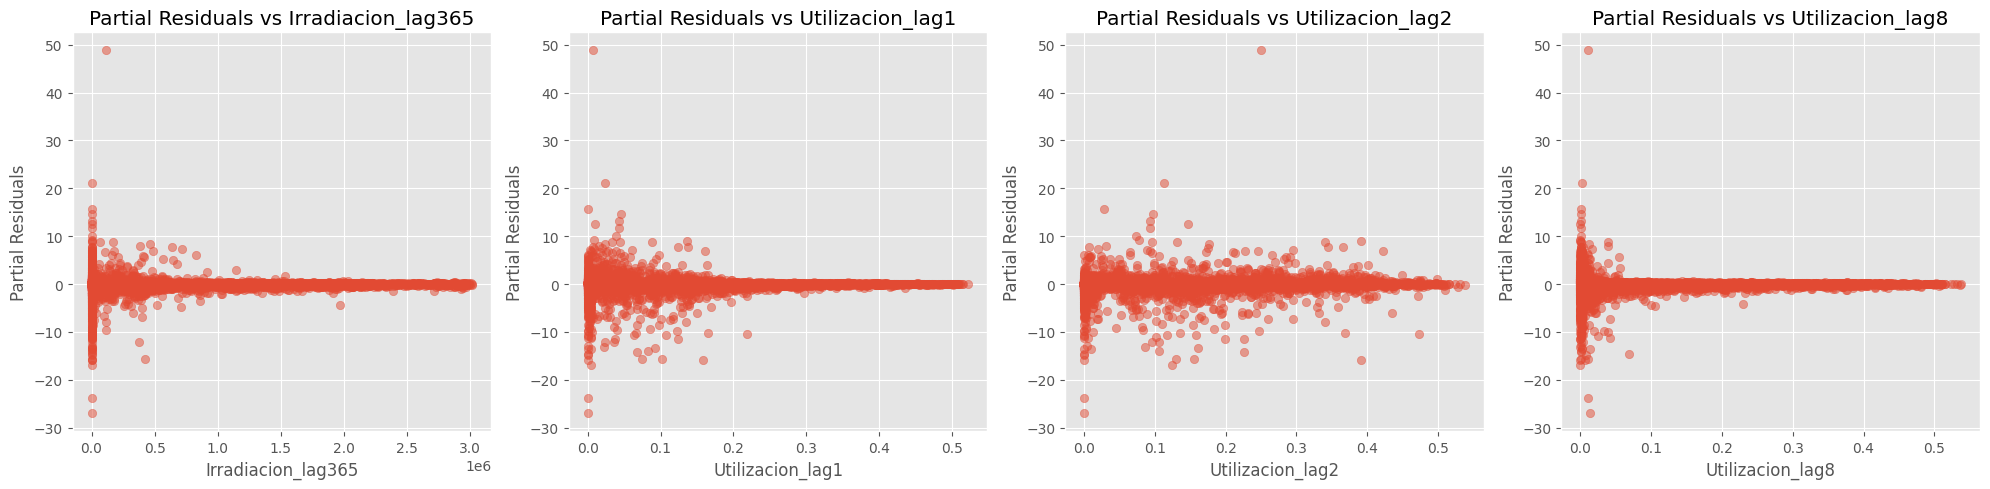

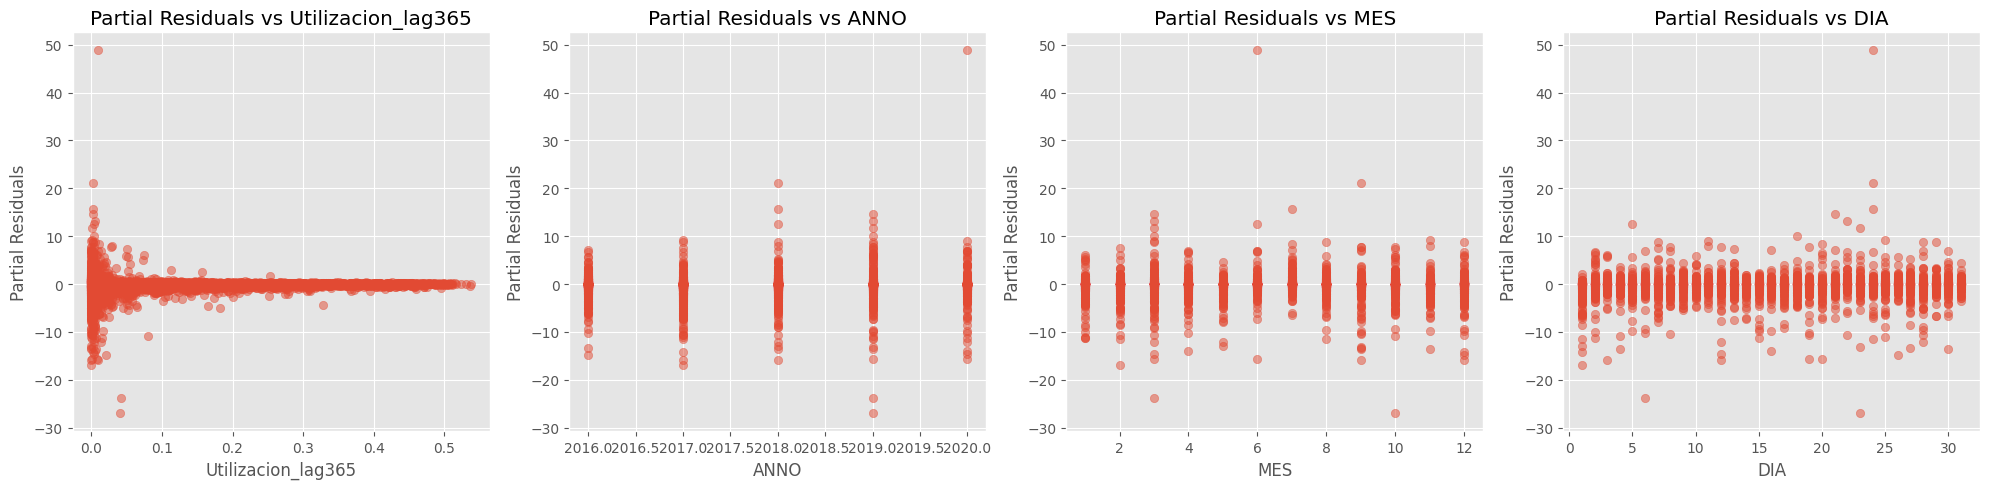

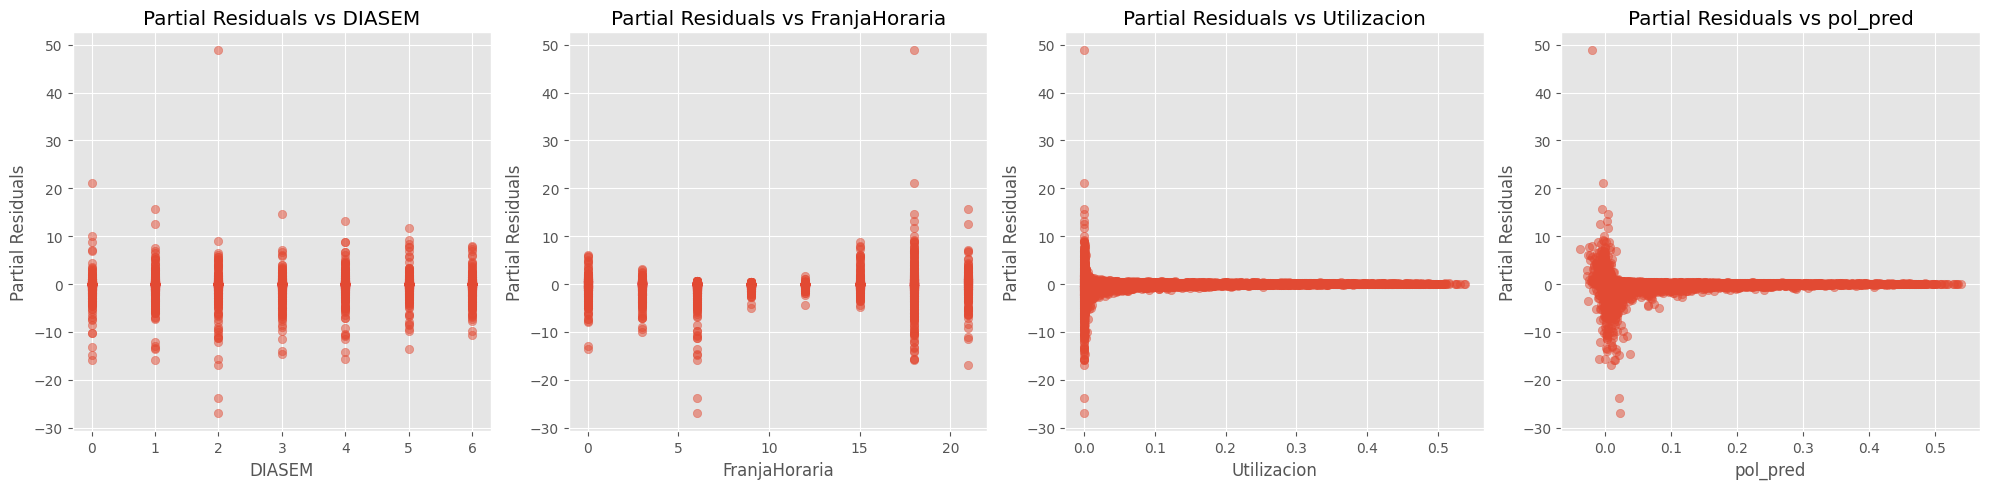

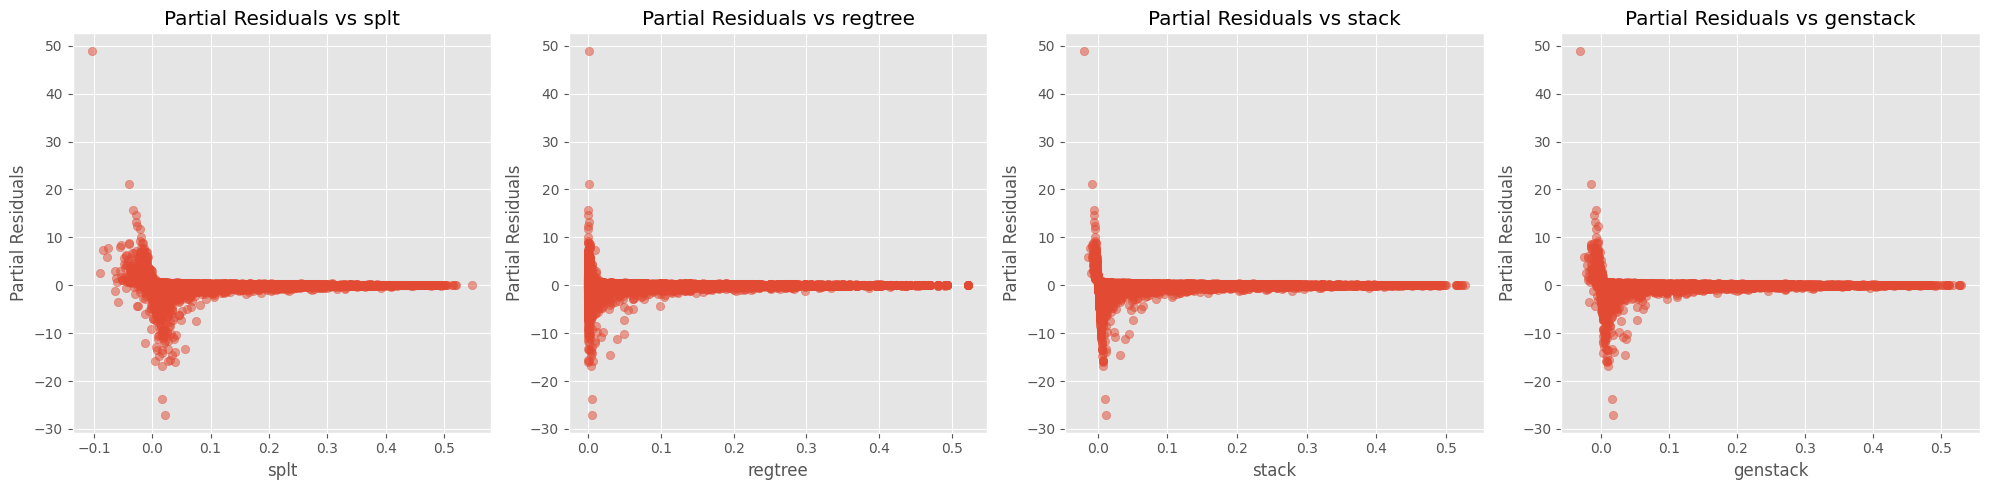

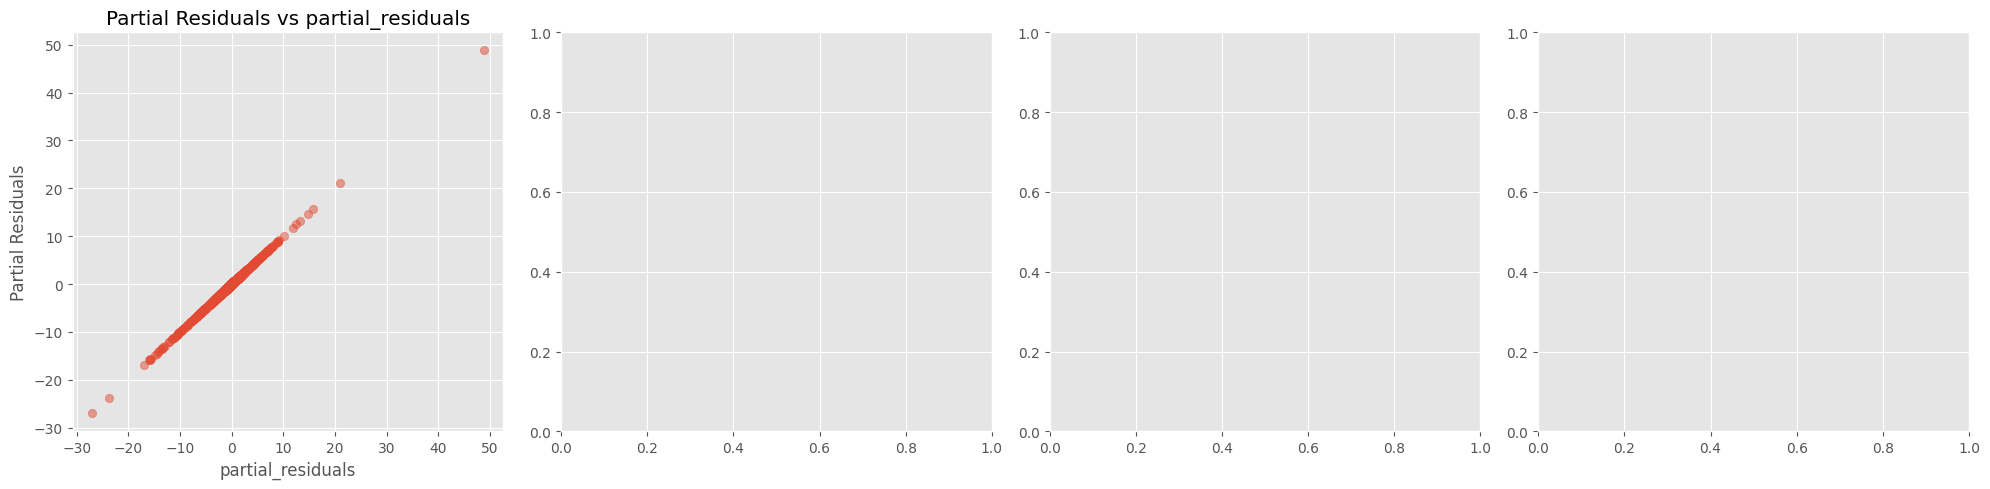

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Partial Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Partial Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()